In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
model_full = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')  
])

In [3]:
weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(200, 200, 3),
                                include_top=False,  # dont include the last dense layers after convolution
                                weights=None)

def model_new_layers(last_output):
    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(2, activation='softmax')(x)
    return x

pre_trained_model.load_weights(weights_file)
for layer in pre_trained_model.layers:
    layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
model = tf.keras.Model(pre_trained_model.input, model_new_layers(last_output))


In [4]:
train_dir='dog vs cat/dataset/training_set'
val_dir = 'dog vs cat/dataset/validation_dir'

train_data_generator = ImageDataGenerator(rescale=1. / 255, rotation_range=30, horizontal_flip=True,vertical_flip=True, shear_range=0.2)    

test_data_generator = ImageDataGenerator(rescale=1. / 255, rotation_range=30, horizontal_flip=True,vertical_flip=True, shear_range=0.2)    


train_generator = train_data_generator.flow_from_directory(
    train_dir,
    shuffle=True,
    target_size=(200, 200),
    batch_size=10,
    class_mode='binary')


val_generator = test_data_generator.flow_from_directory(
    val_dir,
    shuffle=True,
    target_size=(200, 200),
    batch_size=10,
    class_mode='binary')

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

# just added shuffle
history = model.fit(train_generator, shuffle=True, verbose=1,epochs=30,steps_per_epoch=50, validation_data=val_generator)



Found 7900 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Epoch 1/30
50/50 [==============================] - 17s 347ms/step - loss: 0.5925 - accuracy: 0.7840 - val_loss: 0.1878 - val_accuracy: 0.9400
Epoch 2/30
50/50 [==============================] - 17s 346ms/step - loss: 0.2699 - accuracy: 0.8880 - val_loss: 0.2198 - val_accuracy: 0.9200
Epoch 3/30
50/50 [==============================] - 18s 360ms/step - loss: 0.2651 - accuracy: 0.8960 - val_loss: 0.3560 - val_accuracy: 0.8100
Epoch 4/30
50/50 [==============================] - 18s 361ms/step - loss: 0.2479 - accuracy: 0.9060 - val_loss: 0.1567 - val_accuracy: 0.9300
Epoch 5/30
50/50 [==============================] - 18s 361ms/step - loss: 0.2081 - accuracy: 0.9160 - val_loss: 0.3641 - val_accuracy: 0.8700
Epoch 6/30
50/50 [==============================] - 18s 357ms/step - loss: 0.2442 - accuracy: 0.9120 - val_loss: 0.2721 - val_accuracy: 0.8900
Epoch 7/30
50/50 [==============================] - 18s 353

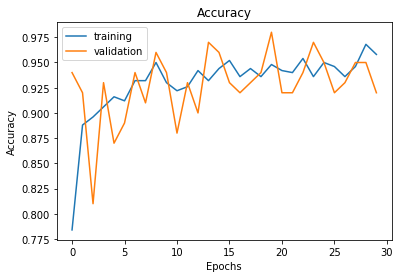

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, label='training')
plt.plot(epochs, val_accuracy, label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy_graph.jpg')
plt.show()
plt.figure()


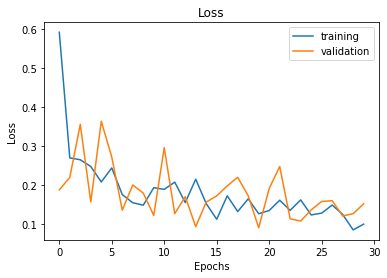

In [6]:
plt.plot(epochs, loss, label='training')
plt.plot(epochs, val_loss, label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Loss_graph.jpg')
plt.show()


In [9]:
cat_dir='dog vs cat/dataset/test_set/cats'
dog_dir='dog vs cat/dataset/test_set/dogs'
test_data=[]

filenames_cats=[f for f in os.listdir(cat_dir) if f.endswith('.jpg')]
filenames_cats.sort()
filenames_dogs=[f for f in os.listdir(dog_dir) if f.endswith('.jpg')]
filenames_dogs.sort()

for i in range(len(filenames_cats)):
    image = Image.open(os.path.join(cat_dir, filenames_cats[i]))
    img = image.resize((200,200))
    test_data.append(np.array(img))
    
for i in range(len(filenames_dogs)):
    image = Image.open(os.path.join(dog_dir, filenames_dogs[i]))
    img = image.resize((200,200))
    test_data.append(np.array(img))


X_test=np.array(test_data)
print(X_test.shape)
X_test = X_test.astype('float32')/255 

pred = model.predict(X_test)
# use predict classes otherwise
predictions=[]
for i in range(pred.shape[0]):
    predictions.append(np.argmax(pred[i,:]))

labels_cats= [0] * len(filenames_cats)
labels_dogs= [1] * len(filenames_dogs)
test_labels= labels_cats + labels_dogs

(2000, 200, 200, 3)


In [10]:
print('Overall Accuracy of the model on holdout testing data is {}'.format(accuracy_score(test_labels, predictions)))

Overall Accuracy of the model on holdout testing data is 0.973


In [11]:
print(confusion_matrix(test_labels,predictions))

[[991   9]
 [ 45 955]]
